In [492]:
!pip install thefuzz

In [493]:
import re, unicodedata, difflib
import pandas as pd
import numpy as np
from collections import defaultdict
from typing import Optional

import matplotlib.pyplot as plt

In [494]:
test = pd.read_csv(r"C:\Users\Utilizador\OneDrive\Documentos\NovaIms\MachineLearning\Project_data\test.csv")
train = pd.read_csv(r"C:\Users\Utilizador\OneDrive\Documentos\NovaIms\MachineLearning\Project_data\train.csv")
brand_model_dic = pd.read_csv(r"C:\Users\Utilizador\OneDrive\Documentos\NovaIms\MachineLearning\brands_models.csv")

## Data Preparation

### carID

In [495]:
df_concat = pd.concat([test, train], ignore_index=True)

duplicates = df_concat.duplicated().any()
print(duplicates)

df_concat[df_concat.duplicated(['carID'])]


False


,carID,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,price


<b>An attribute that contains an identifier for each car.
* The carID variable is 100% distinct across all records, hence we can use it as an index.

In [496]:
test = test.set_index(["carID"])
train = train.set_index(["carID"])

### Brand and Model

In [497]:
print(train["Brand"].unique())

['VW' 'Toyota' 'Audi' 'Ford' 'BMW' 'Skoda' 'Opel' 'Mercedes' 'FOR'
 'mercedes' 'Hyundai' 'w' 'ord' 'MW' 'bmw' nan 'yundai' 'BM' 'Toyot' 'udi'
 'Ope' 'AUDI' 'V' 'opel' 'pel' 'For' 'pe' 'Mercede' 'audi' 'MERCEDES'
 'OPEL' 'koda' 'FORD' 'Hyunda' 'W' 'Aud' 'vw' 'hyundai' 'skoda' 'ford'
 'TOYOTA' 'ercedes' 'oyota' 'toyota' 'SKODA' 'Skod' 'HYUNDAI' 'kod' 'v'
 'for' 'SKOD' 'aud' 'KODA' 'PEL' 'yunda' 'or' 'UDI' 'OYOTA' 'HYUNDA' 'mw'
 'OPE' 'mercede' 'ERCEDES' 'ercede' 'TOYOT' 'MERCEDE' 'ORD' 'ud' 'ope'
 'AUD' 'hyunda' 'skod' 'toyot']


In [498]:
print(train["model"].value_counts())

model
 Focus        6353
 C Class      4886
 Fiesta       4130
 Golf         3081
 Corsa        2182
              ... 
M5               1
 gls class       1
Mokka            1
 6 Serie         1
 JETTA           1
Name: count, Length: 735, dtype: int64


In [499]:
ALLOWED_BRANDS = [
    "Volkswagen","Toyota","Audi","Ford","BMW","Skoda","Opel","Mercedes-Benz","Hyundai"
]

brand_model_dic = brand_model_dic[brand_model_dic["brand"].isin(ALLOWED_BRANDS)].copy()


In [500]:
train["Brand"] = train["Brand"].str.strip()
train["model"] = train["model"].str.strip()

In [501]:
# ---- helpers curtos ----
def norm(s: Optional[str]) -> str:
    if s is None: return ""
    s = unicodedata.normalize("NFKD", str(s).strip().lower())
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    return re.sub(r"[^a-z0-9]+"," ", s).strip()

def fmatch(q: str, keys, cutoff=0.85):
    if not q: return None
    if q in keys: return q
    best,score=None,0.0
    for k in keys:
        r = difflib.SequenceMatcher(None, q, k).ratio()
        if r>score: best,score=k,r
    return best if score>=cutoff else None

# ---- 1) normalizar catálogo (só o necessário) ----
bcol = next(c for c in brand_model_dic.columns if norm(c) in {"brand","marca","make"})
mcol = next(c for c in brand_model_dic.columns if norm(c) in {"model","modelo"})

cat = brand_model_dic.copy()
cat[bcol] = cat[bcol].astype(str).str.replace(r"(?i)^mercedes[\s-]*benz$", "Mercedes", regex=True)

# listas para fuzzy
brand_keys_norm = sorted({norm(b) for b in cat[bcol].dropna().astype(str)})
brand_norm2disp = {norm(b):str(b) for b in cat[bcol].dropna().astype(str)}

# por marca, lista de modelos (normalizado -> display)
models_by_brand = defaultdict(dict)
global_models = {}
brands_by_model_norm = defaultdict(set)  # inferir brand a partir do model
for B,M in cat[[bcol,mcol]].dropna().itertuples(index=False):
    nb, nm = norm(B), norm(M)
    if nb and nm:
        disp_brand = brand_norm2disp[nb]
        models_by_brand[disp_brand][nm] = str(M)
        global_models.setdefault(nm, str(M))
        brands_by_model_norm[nm].add(disp_brand)

# ---- 2) pequenos atalhos/patches ----
BRAND_ALIAS = {
    "vw":"volkswagen", "v w":"volkswagen", "w":"volkswagen",
    "mw":"bmw", "m w":"bmw", "bm":"bmw", "b m":"bmw"   # MW/BM -> BMW
}

PREFERRED_BRAND_BY_MODEL = {
    "corsa":"Opel",               # Corsa é Opel
    "shuttle":"Volkswagen",
    "caddy maxi":"Volkswagen",
    "yeti outdoor":"Skoda",
    "slk":"Mercedes",
    "zafira tourer":"Opel",
    "up":"Volkswagen",
    "u":"Volkswagen",
}

SHORT_OK = {"ka","tt","cc","iq","sl","slk","up","u"}
def is_bad_short(model: str) -> bool:
    q = norm(model)
    if any(ch.isdigit() for ch in q):  # A3, Q5, 308...
        return False
    return (len(q) <= 2) and (q not in SHORT_OK)

# ---- 3) aplicar ao train (fuzzy leve + patches) ----
t_bcol = next(c for c in train.columns if norm(c) in {"brand","marca","make"})
t_mcol = next(c for c in train.columns if norm(c) in {"model","modelo"})

bn_list, mn_list = [], []
for b0, m0 in train[[t_bcol, t_mcol]].itertuples(index=False):
    nb0, nm0 = norm(b0), norm(m0)

    # brand: alias; senão fuzzy
    nbq = BRAND_ALIAS.get(nb0, nb0)
    b_key = fmatch(nbq, brand_keys_norm, cutoff=0.85)
    b = brand_norm2disp.get(b_key, "") if b_key else ""

    # model: tenta por marca; se falhar, tenta global
    m = ""
    if nm0:
        if b and b in models_by_brand:
            k = fmatch(nm0, list(models_by_brand[b].keys()), cutoff=0.85)
            if k: m = models_by_brand[b][k]
        if not m:
            k = fmatch(nm0, list(global_models.keys()), cutoff=0.78)
            if k:
                m = global_models[k]
                # se reconheci o modelo globalmente e a brand está vazia, inferir a brand
                if not b:
                    cands = list(brands_by_model_norm.get(k, []))
                    if len(cands) == 1:
                        b = cands[0]

    # se não há brand mas o modelo denuncia a marca
    if not b and nm0 in PREFERRED_BRAND_BY_MODEL:
        b = PREFERRED_BRAND_BY_MODEL[nm0]
        if not m: m = str(m0).strip()

    # não deitar fora modelos curtos válidos
    if m and is_bad_short(m):
        m = ""

    bn_list.append(b)
    mn_list.append(m if m is not None else "")

# >>> altera as colunas originais <<<
train[t_bcol] = pd.Series(bn_list, index=train.index).fillna("").astype(str)
train[t_mcol] = pd.Series(mn_list, index=train.index).fillna("").astype(str)

print("Clean (light) feito — valores escritos em", t_bcol, "e", t_mcol, "(sem pós-processamento por modas).")


Clean (light) feito — valores escritos em Brand e model (sem pós-processamento por modas).


In [502]:
# 1) Converter vazios em NaN (Brand e model)
for c in ["Brand", "model"]:
    train[c] = (
        train[c]
        .replace("", None, regex=True)       
    )

In [503]:
print(train["Brand"].unique())

['Volkswagen' 'Toyota' 'Audi' 'Ford' 'BMW' 'Skoda' 'Opel' 'Mercedes'
 'Hyundai' None]


In [504]:
print(train["model"].value_counts())

model
Focus            6915
C-Class          5288
Fiesta           4470
Golf             3261
Corsa            2359
                 ... 
S5                  1
CLC-Class           1
SLK                 1
Terracan            1
Zafira Tourer       1
Name: count, Length: 188, dtype: int64


### year

In [505]:
train["year"].unique()

array([2016.        , 2019.        , 2018.        , 2014.        ,
       2017.        , 2020.        , 2013.        ,           nan,
       2015.        , 2023.36707842, 2011.        , 2012.        ,
       2023.1169636 , 2003.        , 2009.        , 2007.        ,
       2005.        , 2011.11118842, 2011.21085349, 2023.97731126,
       2004.        , 2010.        , 2010.56500919, 2008.        ,
       2024.12175905, 2006.        , 2023.60527574, 2023.38982198,
       2010.67696784, 2001.        , 2000.        , 2023.26798867,
       2010.26863473, 2010.37154646, 2002.        , 2022.69668507,
       2009.81675711, 2010.7464032 , 2012.69574039, 1996.        ,
       1998.        , 2022.87800554, 1970.        , 1999.        ,
       1997.        ])

In [506]:
#por agora nulos ficom com 9999
train["year"] = train["year"].fillna(9999)

# Ficar só com a parte inteira e converter para int
train["year"] = train["year"].astype(float).astype(int)
train.loc[train["year"] == 9999, "year"] = pd.NA

print(train["year"].unique())

[2016. 2019. 2018. 2014. 2017. 2020. 2013.   nan 2015. 2023. 2011. 2012.
 2003. 2009. 2007. 2005. 2004. 2010. 2008. 2024. 2006. 2001. 2000. 2002.
 2022. 1996. 1998. 1970. 1999. 1997.]


### transmission       

In [507]:
train["transmission"].unique()

array(['Semi-Auto', 'Manual', 'anual', 'Semi-Aut', 'Automatic', 'manual',
       nan, 'unknown', 'Manua', 'AUTOMATIC', 'MANUAL', 'semi-auto',
       ' Manual ', 'automatic', 'emi-Auto', 'SEMI-AUTO', 'SEMI-AUT',
       'Automati', 'ANUAL', 'utomatic', 'unknow', 'EMI-AUTO', 'manua',
       'anua', 'emi-Aut', 'MANUA', 'emi-auto', 'UTOMATIC', ' manual ',
       ' MANUAL ', 'UNKNOWN', 'nknown', 'automati', 'Other', 'semi-aut',
       ' Manual', 'AUTOMATI', 'utomati', 'Manual ', 'manual ', 'nknow'],
      dtype=object)

In [508]:
# normalização mínima: lowercase, trocar hífens/underscores por espaço e colapsar espaços
def _norm_tx(s):
    if pd.isna(s):
        return ""
    s = str(s).lower().strip()
    s = s.replace("-", " ").replace("_", " ")
    return re.sub(r"\s+", " ", s)

CANON = {
    "Automatic": "automatic",
    "Semi-automatic": "semi automatic",
    "Manual": "manual",
    "Unknown": "unknown",
    "Other": "other",
}

def tx_simple(x, cutoff=0.65):
    s = _norm_tx(x)
    if not s:
        return None

    # 1) matches diretos por inclusão (ordem importa)
    if "emi" in s and "aut" in s:
        return "Semi-automatic"
    if "manual" in s:
        return "Manual"
    if "automatic" in s or "auto" in s:
        return "Automatic"
    if "unknown" in s:
        return "Unknown"
    if "other" in s:
        return "Other"

    # 2) fallback: fuzzy leve contra os 5 alvos
    best_label, best = None, 0.0
    for label, key in CANON.items():
        r = difflib.SequenceMatcher(None, s, key).ratio()
        if r > best:
            best_label, best = label, r

    return best_label if best >= cutoff else None  # sem match → None

train["transmission"] = train["transmission"].apply(tx_simple)


### mileage

count         74510.0
mean     23470.107892
std      21635.014065
min               1.0
50%           17530.0
90%           51250.1
95%           67000.0
99%          97921.99
max          323000.0
Name: mileage, dtype: Float64


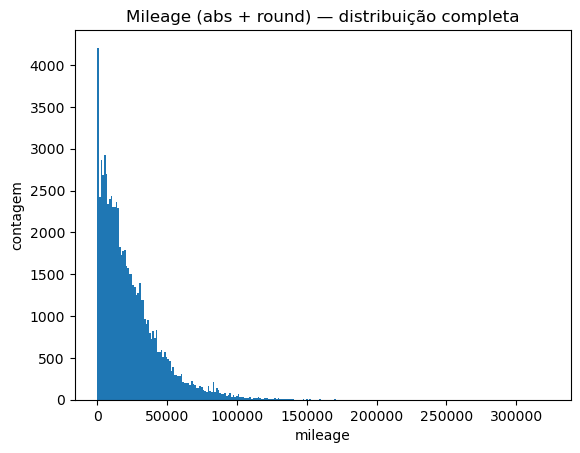

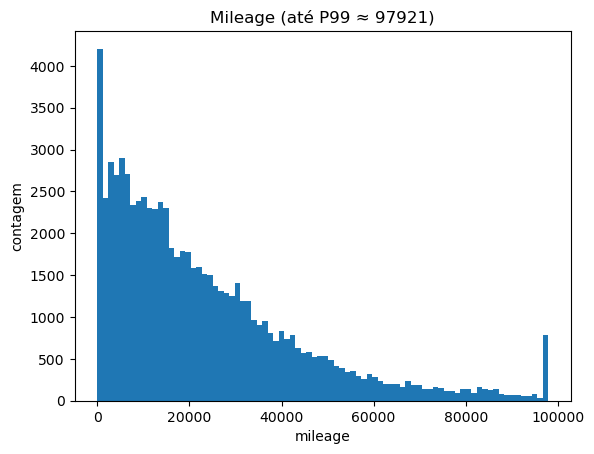

In [509]:
# 1) Limpeza: absoluto + arredondado (preserva NaN)
train["mileage"] = (
    pd.to_numeric(train["mileage"], errors="coerce")
      .abs()
      .round()
      .astype("Int64")
)

# 2) Resumo
print(train["mileage"].describe(percentiles=[0.50, 0.90, 0.95, 0.99]))

# 3) Histograma — intervalo completo
s = train["mileage"].dropna()
plt.figure()
plt.hist(s, bins="auto")
plt.title("Mileage (abs + round) — distribuição completa")
plt.xlabel("mileage"); plt.ylabel("contagem")
plt.show()

# 4) Histograma — “zoom” até P99 (usar limite inteiro para manter dtype)
p99 = int(s.quantile(0.99))
plt.figure()
plt.hist(s.clip(upper=p99), bins="auto")
plt.title(f"Mileage (até P99 ≈ {p99})")
plt.xlabel("mileage"); plt.ylabel("contagem")
plt.show()


### fuelType

In [510]:
train["fuelType"].unique()

array(['Petrol', 'Diesel', 'etrol', 'Hybrid', 'diesel', 'iesel', nan,
       'petrol', 'PETROL', 'Diese', 'Petro', 'DIESEL', 'petro', 'HYBRID',
       'ybri', 'Other', 'DIESE', 'Hybri', 'ETROL', 'ybrid', 'PETRO',
       'hybrid', 'IESEL', 'Electric', 'ther', 'iese', 'etro', 'ETRO',
       'diese', 'Othe', 'YBRID', 'HYBRI', 'OTHER', 'other', 'IESE'],
      dtype=object)

In [511]:
# normalização mínima
def _norm_fuel(s):
    if pd.isna(s):
        return ""
    s = str(s).lower().strip()
    s = s.replace("-", " ").replace("_", " ")
    return re.sub(r"\s+", " ", s)

FUEL_CANON = {
    "Petrol":   "petrol",
    "Diesel":   "diesel",
    "Hybrid":   "hybrid",
    "Electric": "electric",
    "Other":    "other",
}

def fuel_simple(x, cutoff=0.60):
    s = _norm_fuel(x)
    if not s:
        return None

    # matches diretos por inclusão (a maioria dos typos comuns)
    if any(tok in s for tok in ("petrol","petro","etrol","etro")):
        return "Petrol"
    if any(tok in s for tok in ("diesel","diese","dies","iesel","iese")):
        return "Diesel"
    if any(tok in s for tok in ("hybrid","hybri","hybr","hyb","ybrid","ybri")):
        return "Hybrid"
    if any(tok in s for tok in ("electric","electri","elec","eletric","lectr")):
        return "Electric"
    if any(tok in s for tok in ("other","othe","ther")):
        return "Other"

    # fallback fuzzy leve contra os 5 alvos
    best_label, best = None, 0.0
    for label, key in FUEL_CANON.items():
        r = difflib.SequenceMatcher(None, s, key).ratio()
        if r > best:
            best_label, best = label, r

    return best_label if best >= cutoff else None  # sem match → None

train["fuelType"] = train["fuelType"].apply(fuel_simple)

print(train["fuelType"].unique())

['Petrol' 'Diesel' 'Hybrid' None 'Other' 'Electric']


### tax

In [512]:
# 1) Limpeza: absoluto + arredondado (preserva NaN)
train["tax"] = (
    pd.to_numeric(train["tax"], errors="coerce")
      .abs()
)

### mpg

In [513]:
# 1) Limpeza: absoluto + arredondado (preserva NaN)
train["mpg"] = (
    pd.to_numeric(train["mpg"], errors="coerce")
      .abs()
)

### engineSize

In [514]:
# 1) Limpeza: absoluto + arredondado (preserva NaN)
train["engineSize"] = (
    pd.to_numeric(train["engineSize"], errors="coerce")
      .abs()
)

### paintQuality%

In [515]:
train["paintQuality%"] = (
    pd.to_numeric(train["paintQuality%"], errors="coerce")  # preserva null como NaN
      .clip(lower=0, upper=100)                             # <0 → 0 ; >100 → 100
)

### previousOwners

In [516]:
# Substituir NaN por 9999 (ou outro valor que prefiras, ex: 0)
train["previousOwners"] = train["previousOwners"].fillna(9999)

# Converter para inteiro
train["previousOwners"] = train["previousOwners"].astype(float).astype(int)

# Tornar valores negativos em positivos
train["previousOwners"] = train["previousOwners"].abs()

print(train["previousOwners"].unique())

[   4    1    2    3    0 9999    6]


### hasDamage

In [517]:
train["hasDamage"].unique()
#para apagar a variavel que nao tem nada de jeito

array([ 0., nan])

In [518]:
train["hasDamage"].unique()

array([ 0., nan])

In [519]:
# fazer exploração da media 

In [520]:
train_0 = train[train["hasDamage"]== 0]
train_nan = train[~(train["hasDamage"] == 0)]


In [521]:
train_0["price"].median()

14698.0

In [522]:
train_nan["price"].median()

14798.0

In [523]:
train.to_csv("clean.csv")

In [524]:
train.isna().sum()

Brand               45
model             2321
year              1491
price                0
transmission      1522
mileage           1463
fuelType          1511
tax               7904
mpg               7926
engineSize        1516
paintQuality%     1524
previousOwners       0
hasDamage         1548
dtype: int64

### Missing values

Brand and Model

mpg nao devia ser nulo nos eletricos?

In [526]:
# --- helpers ----------------------------
def _mode(s: pd.Series):
    s = s.dropna()
    return s.mode().iloc[0] if not s.empty else np.nan

def fill_numeric_hier(df, col, groupings, integer=False):
    # trabalhar em float para permitir preencher com medianas
    df[col] = pd.to_numeric(df[col], errors="coerce").astype("Float64")

    for grp in groupings:
        med = df.groupby(list(grp), dropna=True)[col].transform("median")
        # preenche apenas onde está NaN
        df[col] = df[col].where(df[col].notna(), med)

    # fallback global se ainda houver NaN
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].median())

    # se a coluna é inteira, arredonda e volta a Int64 (nullable)
    if integer:
        df[col] = df[col].round().astype("Int64")
        

def fill_categ_hier(df: pd.DataFrame, col: str, groupings: list[tuple]):
    """Preenche NaN de df[col] por modas hierárquicas; no fim usa moda global."""
    for grp in groupings:
        mod = df.groupby(list(grp), dropna=True)[col].transform(_mode)
        df[col] = df[col].fillna(mod)
    if df[col].isna().any():
        df[col] = df[col].fillna(_mode(df[col]))
    return df

# --- saneamento mínimo antes de imputar ---
# year: 9999 -> NaN
train["year"] = pd.to_numeric(train["year"], errors="coerce")
train.loc[train["year"] == 9999, "year"] = np.nan

# mileage: garantir numérico
train["mileage"] = pd.to_numeric(train["mileage"], errors="coerce")

# tax / mpg / engineSize / paintQuality% / previousOwners: garantir numéricos
for c in ["tax", "mpg", "engineSize", "paintQuality%", "previousOwners"]:
    train[c] = pd.to_numeric(train[c], errors="coerce")

# paintQuality% já foi “clampado” algures; mas garantimos novamente por segurança
train["paintQuality%"] = train["paintQuality%"].where(train["paintQuality%"].isna(),
                                                     train["paintQuality%"].clip(lower=0, upper=100))

# --- imputações --------------------------
grp_bmy = [("Brand","model","year"), ("Brand","model"), ("Brand",)]
grp_fuel = [("year","fuelType","engineSize"), ("year","fuelType"), ("fuelType",), ("year",)]
grp_engine = [("model","year"), ("model",), ("Brand",)]

# Categóricas (se ainda houver NaN depois das normalizações que já fizeste)
for col in ["fuelType", "transmission", "Brand", "model"]:
    if col in train.columns:
        if train[col].isna().any():
            fill_categ_hier(train, col, grp_bmy)

# exemplos de agrupamentos


fill_numeric_hier(train, "year",            [("Brand","model")], integer=True)
fill_numeric_hier(train, "mileage",         grp_bmy,            integer=True)
fill_numeric_hier(train, "tax",             grp_fuel,           integer=True)
fill_numeric_hier(train, "previousOwners",  grp_bmy,            integer=True)

fill_numeric_hier(train, "mpg",             grp_fuel,           integer=False)
fill_numeric_hier(train, "engineSize",      grp_bmy,            integer=False)
fill_numeric_hier(train, "paintQuality%",   grp_bmy,            integer=False)


# Pós-tratamento de tipos: inteiros onde faz sentido
# mileage e previousOwners inteiros não-negativos
train["mileage"] = train["mileage"].round().abs().astype("Int64")
train["previousOwners"] = train["previousOwners"].round().clip(lower=0).astype("Int64")

# year inteiro
train["year"] = train["year"].round().astype("Int64")

# (Opcional) pequeno resumo
print("NAs por coluna (depois):")
print(train.isna().sum().sort_values(ascending=False))

# Nota: 'price' (alvo) fica como está – não é imputado aqui.


NAs por coluna (depois):
hasDamage         1548
model                0
year                 0
price                0
Brand                0
transmission         0
mileage              0
tax                  0
fuelType             0
mpg                  0
engineSize           0
paintQuality%        0
previousOwners       0
dtype: int64


Os eletricos têm de ser automaticos, mas automaticos nao podem ser eletricos.
mpg nao devia ser 0 em eletricos?
ha carros que sejam especificamente eletricos? 
temos de mudar o o unknown para null, ou o null para unknown talvez

In [527]:
train.to_csv("clean_preenchido.csv")

### Feature Selection

In [528]:
# remover a coluna 'hasDamage' do DataFrame train
train.drop(columns=["hasDamage"], inplace=True, errors="ignore")

In [530]:
train.to_csv("clean_sem_damage.csv")

In [532]:
train_original = train.copy()

In [534]:
# %% Feature engineering + pipeline + permutation importance (corrigido)

import numpy as np
import pandas as pd

# --- 1) features simples ---
# garantir tipos mínimos
train["year"]    = pd.to_numeric(train["year"], errors="coerce")
train["mileage"] = pd.to_numeric(train["mileage"], errors="coerce")

# regra anterior: year==9999 -> NaN
train.loc[train["year"] == 9999, "year"] = np.nan

# feature: age (anos desde o mais recente do dataset)
if train["year"].notna().any():
    latest_year = int(np.nanmax(train["year"]))
else:
    latest_year = None

train["age"] = latest_year - train["year"] if latest_year is not None else np.nan

# feature: mileage per year (evitar divisão por zero)
train["mileage_per_year"] = np.where(
    (train["age"].notna()) & (train["age"] > 0),
    train["mileage"] / train["age"],
    np.nan
)

# --- 2) X / y e tipagem ---
TARGET = "price"
X = train.drop(columns=[c for c in [TARGET] if c in train.columns]).copy()
y = pd.to_numeric(train[TARGET], errors="coerce")

# remover linhas sem y (modelos não treinam com y NaN)
mask_ok = y.notna()
X = X.loc[mask_ok].reset_index(drop=True)
y = y.loc[mask_ok].reset_index(drop=True)

num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

# --- 3) pipeline ---
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor

def make_ohe():
    # compat com versões do sklearn
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", make_ohe())
])

pre = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

model = HistGradientBoostingRegressor(random_state=42)
pipe = Pipeline(steps=[("pre", pre), ("model", model)])

# --- 4) holdout + treino ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42
)
pipe.fit(X_train, y_train)

# --- 5) permutation importance ---
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    pipe, X_val, y_val,
    n_repeats=10, random_state=42, scoring="r2"
)

# --- 6) nomes de features pós-transformação + agregação ---
def get_feature_names(pipe, num_cols, cat_cols):
    pre = pipe.named_steps["pre"]
    names = []
    # numéricas: nomes originais
    names.extend(list(num_cols))
    # categóricas: nomes do OneHot
    ohe = pre.named_transformers_["cat"].named_steps["onehot"]
    ohe_names = ohe.get_feature_names_out(cat_cols).tolist()
    names.extend(ohe_names)
    return names

feat_names = get_feature_names(pipe, num_cols, cat_cols)

# alinhar comprimentos se necessário (robustez)
if len(feat_names) != len(perm.importances_mean):
    feat_names = [f"feat_{i}" for i in range(len(perm.importances_mean))]

imp_df = pd.DataFrame({
    "feature_out": feat_names,
    "imp_mean": perm.importances_mean,
    "imp_std":  perm.importances_std
})

def original_col(name: str) -> str:
    # OneHotEncoder usa "col_categoria"; numéricas = nome direto
    s = str(name)
    for col in cat_cols:
        if s.startswith(col + "_"):
            return col
    return s

imp_df["orig_col"] = imp_df["feature_out"].apply(original_col)
group_imp = (imp_df.groupby("orig_col", as_index=False)
             .agg(imp_sum=("imp_mean", "sum"),
                  imp_max=("imp_mean", "max"),
                  parts=("imp_mean", "size"))
             .sort_values("imp_sum", ascending=False))

to_drop = group_imp.loc[group_imp["imp_sum"] <= 0, "orig_col"].tolist()

print("\n=== Ranking de importância por coluna original (Permutation Importance) ===")
print(group_imp.to_string(index=False))
print("\nSugestão inicial de remoção (imp_sum <= 0):", to_drop if to_drop else "nenhuma")

from sklearn.metrics import r2_score, mean_absolute_error
y_pred = pipe.predict(X_val)
print(f"\nHoldout R²: {r2_score(y_val, y_pred):.3f} | MAE: {mean_absolute_error(y_val, y_pred):.1f}")



=== Ranking de importância por coluna original (Permutation Importance) ===
orig_col  imp_sum  imp_max  parts
  feat_8 0.252513 0.252513      1
  feat_2 0.144295 0.144295      1
  feat_3 0.114870 0.114870      1
  feat_4 0.104231 0.104231      1
  feat_0 0.102578 0.102578      1
  feat_7 0.099742 0.099742      1
  feat_1 0.051456 0.051456      1
  feat_5 0.015160 0.015160      1
  feat_6 0.004909 0.004909      1
 feat_11 0.001853 0.001853      1
 feat_12 0.001352 0.001352      1
  feat_9 0.000411 0.000411      1
 feat_10 0.000001 0.000001      1

Sugestão inicial de remoção (imp_sum <= 0): nenhuma

Holdout R²: 0.933 | MAE: 1593.0


In [536]:
train.to_csv("after_fs.csv")